In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../dataset/call_volume.csv')
df.head()

/var/folders/s5/_19scpmn5qx24kgxtpzykrz00000gn/T/ipykernel_13566/3601655187.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/cuongnguyen/Master/Data Science/course project/dataset/combined_queues_samres.csv')


,ServiceID,Time_stamp,Answered,WaitingAnswered,Talking,WaitingAbandoned,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,18,2022-01-01 01:21:15.000,1,37,466.0,NaN,NaN,NaN,Telephone queue 1,NaN
1,18,2022-01-01 02:07:56.000,1,3,360.0,NaN,NaN,NaN,Service ID - 18,NaN
2,18,2022-01-01 02:39:06.000,1,59,197.0,NaN,NaN,NaN,Open 24 hours a day,NaN
3,18,2022-01-01 04:01:33.000,1,13,134.0,NaN,NaN,NaN,NaN,NaN
4,18,2022-01-01 07:05:38.000,1,45,19.0,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'], axis=1)
df = df.rename({'ServiceID':'callgroupid','Time_stamp':'timestamp','Answered':'answered','WaitingAnswered':'gap','Talking':'duration','WaitingAbandoned':'drop'}, axis=1)
df.head(10)

,callgroupid,timestamp,answered,gap,duration,drop
0,18,2022-01-01 01:21:15.000,1,37,466.0,NaN
1,18,2022-01-01 02:07:56.000,1,3,360.0,NaN
2,18,2022-01-01 02:39:06.000,1,59,197.0,NaN
3,18,2022-01-01 04:01:33.000,1,13,134.0,NaN
4,18,2022-01-01 07:05:38.000,1,45,19.0,NaN
5,18,2022-01-01 07:07:19.000,1,5,224.0,NaN
6,18,2022-01-01 07:11:36.000,1,3,11.0,NaN
7,18,2022-01-01 09:39:16.000,1,15,122.0,NaN
8,18,2022-01-01 10:06:56.000,1,4,99.0,NaN
9,18,2022-01-01 10:29:50.000,1,17,157.0,NaN


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.set_index('timestamp', inplace=True) 
# # df.index = pd.to_datetime(df['timestamp'])
ts_df = df.resample('15T').count()
# resampled_df = resampled_df.rename(columns={'value': 'occurrence'})
ts_df = ts_df.drop(['answered','duration','gap','drop'], axis=1)
ts_df = ts_df.rename({'callgroupid':'callvolume'},axis=1)
# resampled_df.drop(['timestamp','hour_of_day','day_of_week'],axis=1)
ts_df.head()

,callvolume
timestamp,
2022-01-01 00:00:00,12
2022-01-01 00:15:00,26
2022-01-01 00:30:00,57
2022-01-01 00:45:00,54
2022-01-01 01:00:00,55


In [6]:
ts_df.isnull().sum()
ts_df = ts_df.dropna()
ts_df.isnull().sum()

callvolume    0
dtype: int64

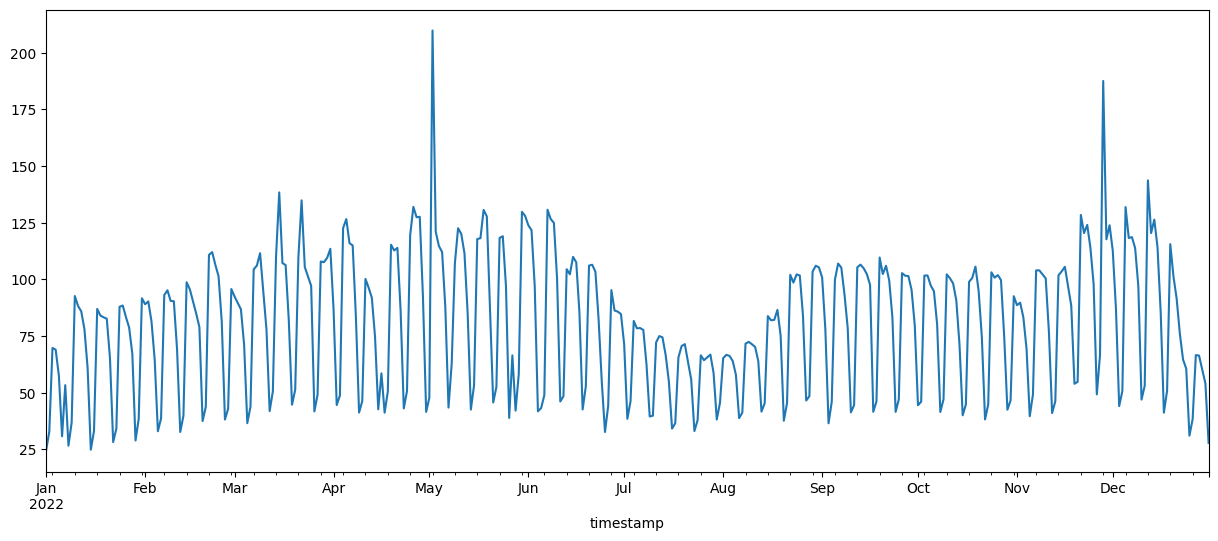

In [7]:
ts_day_avg = ts_df['callvolume'].resample('D').mean()
ts_day_avg.plot(figsize = (15, 6))
plt.show()

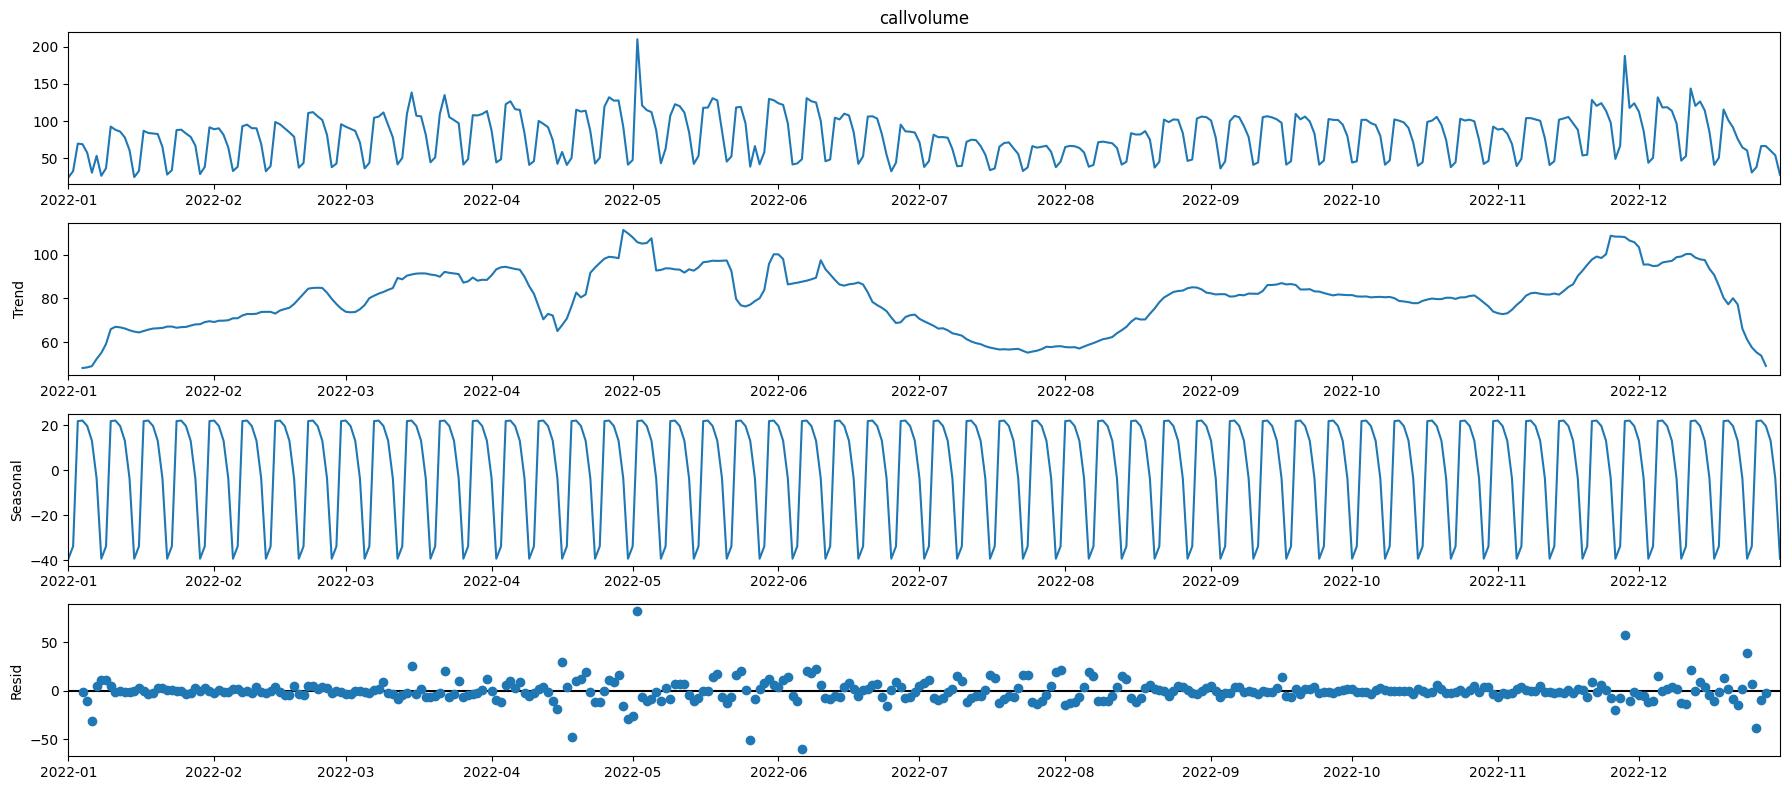

In [8]:
from pylab import rcParams
import pmdarima as pm
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_day_avg, model='additive')
fig = decomposition.plot()
plt.show()

In [9]:
# ad_fuller_result = adfuller(data['data'])
# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(ts_day_avg))

Results of Dickey-Fuller Test:
Test Statistic                  -2.836558
p-value                          0.053238
#Lags Used                      17.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64
None


In [11]:
# from statsmodels.graphics.tsaplots import plot_acf

# # Assuming you have a time series stored in a pandas DataFrame called 'ts'
# # with a column 'value' representing the values

# # Compute autocorrelation
# autocorrelation = pd.Series(ts_df['callvolume']).autocorr()

# # Plot autocorrelation
# plot_acf(ts_df['callvolume'], lags=192)  # Adjust the 'lags' parameter as needed
# plt.title('Autocorrelation of Time Series')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.712843e+00
p-value                        1.250526e-11
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64
None


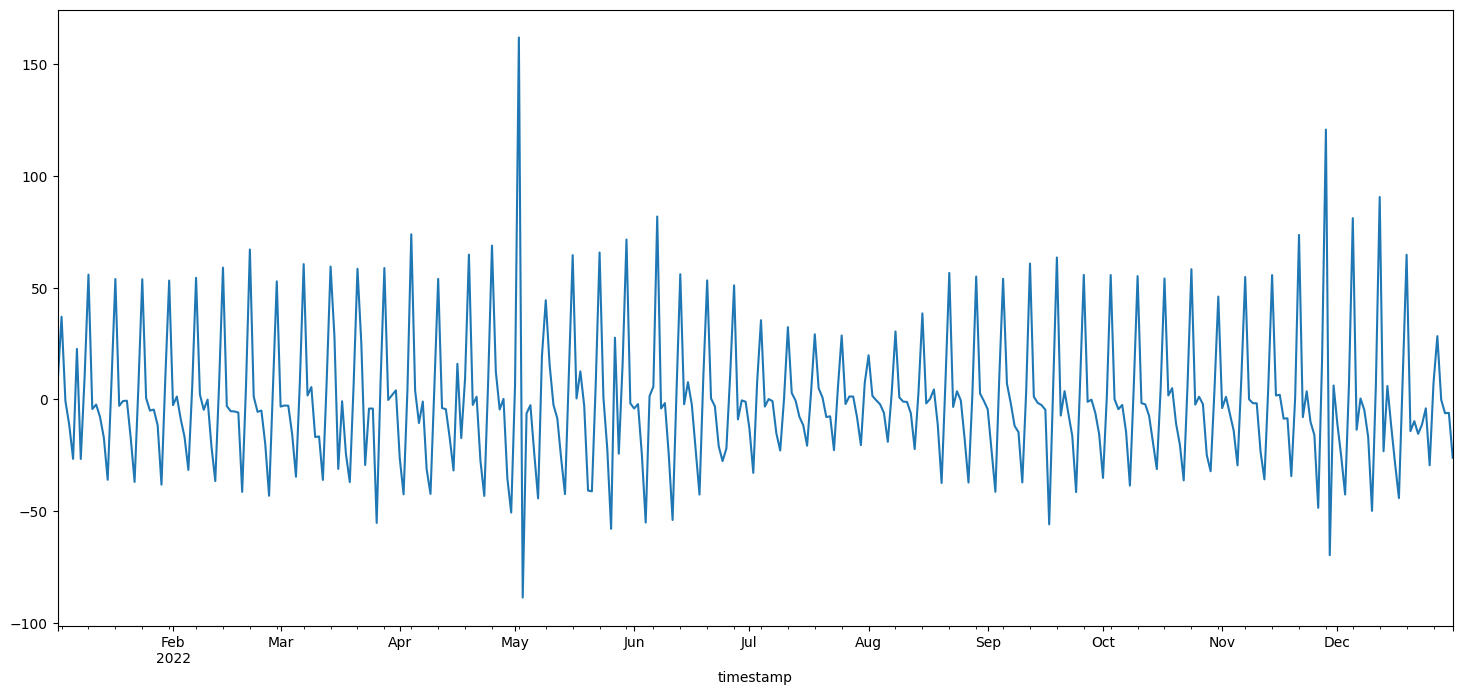

In [12]:
# from pmdarima.arima.stationarity import ADFTest
ts_t_adj = ts_day_avg - ts_day_avg.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

# adf_test = ADFTest(alpha=0.05)
# print(adf_test.is_stationary(ts_t_adj))
print(adf_test(ts_t_adj))

<AxesSubplot: xlabel='timestamp'>

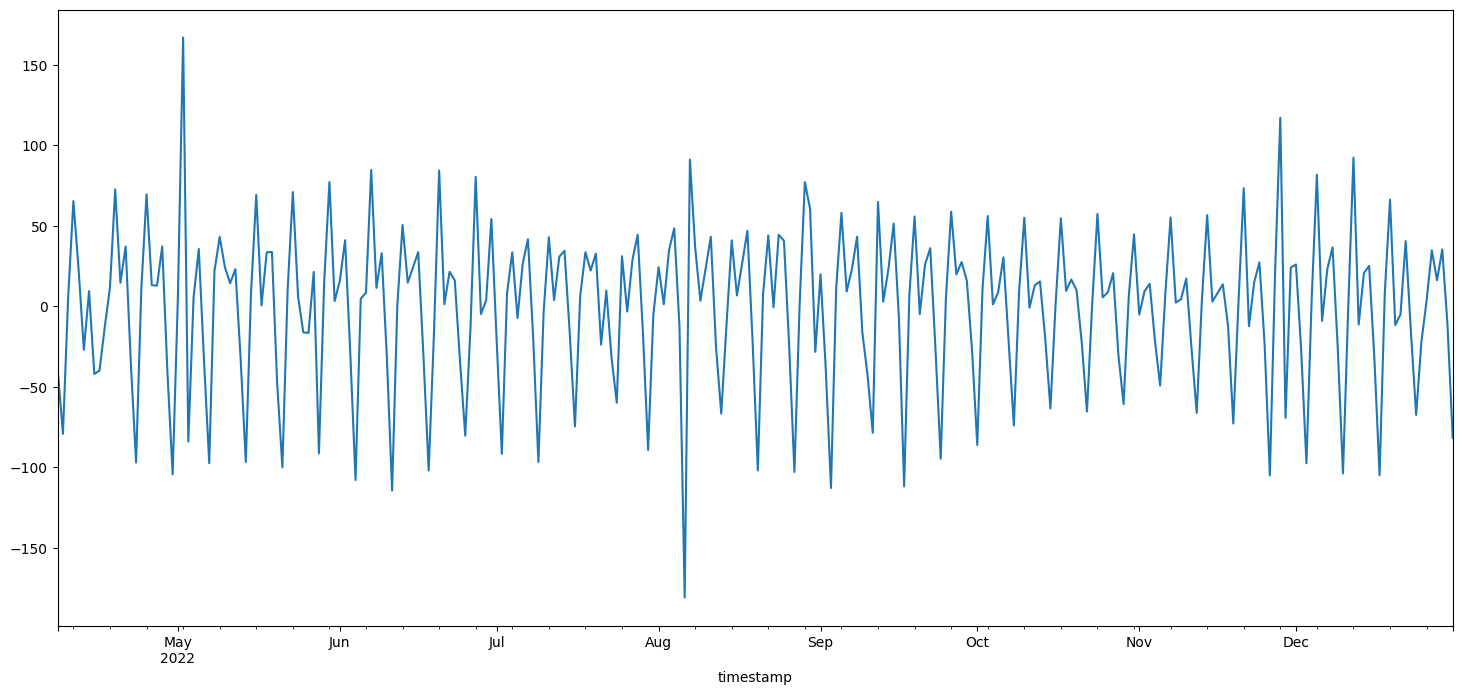

In [13]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(96)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

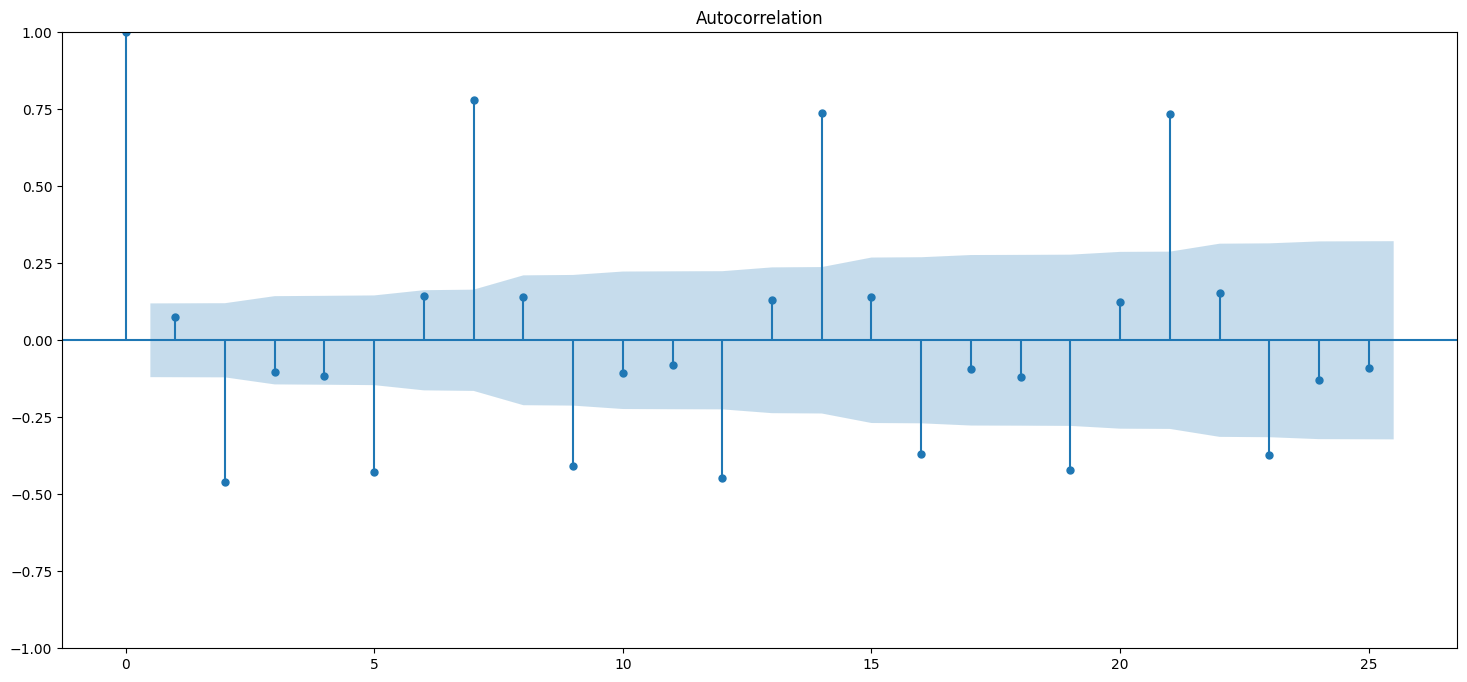

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


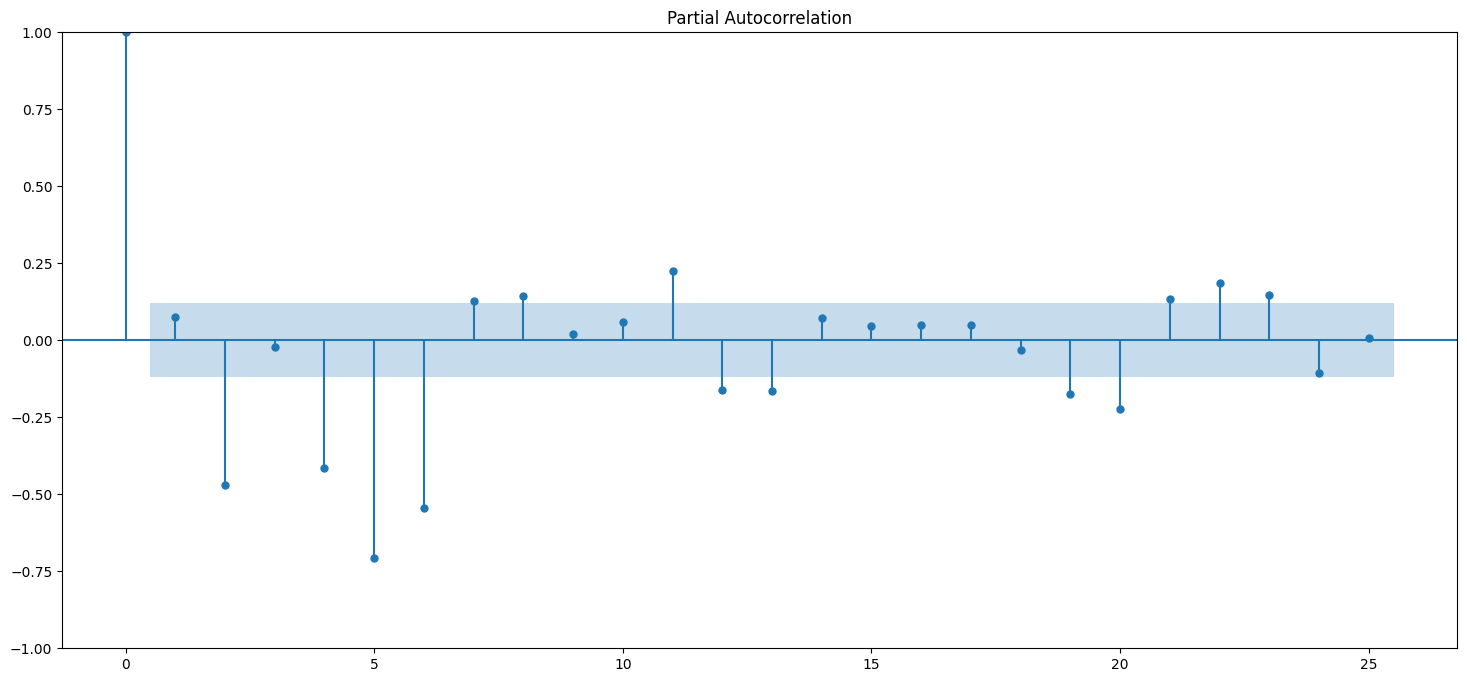

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_s_adj)
plt.show()
plot_pacf(ts_s_adj)
plt.show()

In [15]:
# import itertools
# import statsmodels.api as sm

# p = range(0, 3)
# d = range(0, 2)
# q = range(0, 3)

# pdq = list(itertools.product(p, d, q))

# aic_results = []
# for param in pdq:
#     try:
#         mod = sm.tsa.statespace.SARIMAX(ts_df, order=param, seasonal_order=(0, 0, 0, 0))
#         results = mod.fit()
#         aic_results.append((param, results.aic))
#     except:
#         continue
        
# best_params, best_aic = min(aic_results, key=lambda x: x[1])
# print("Best parameters:", best_params)

In [16]:
train_start_dt = '2022-11-01 00:00:00'
test_start_dt = '2022-12-01 00:00:00'

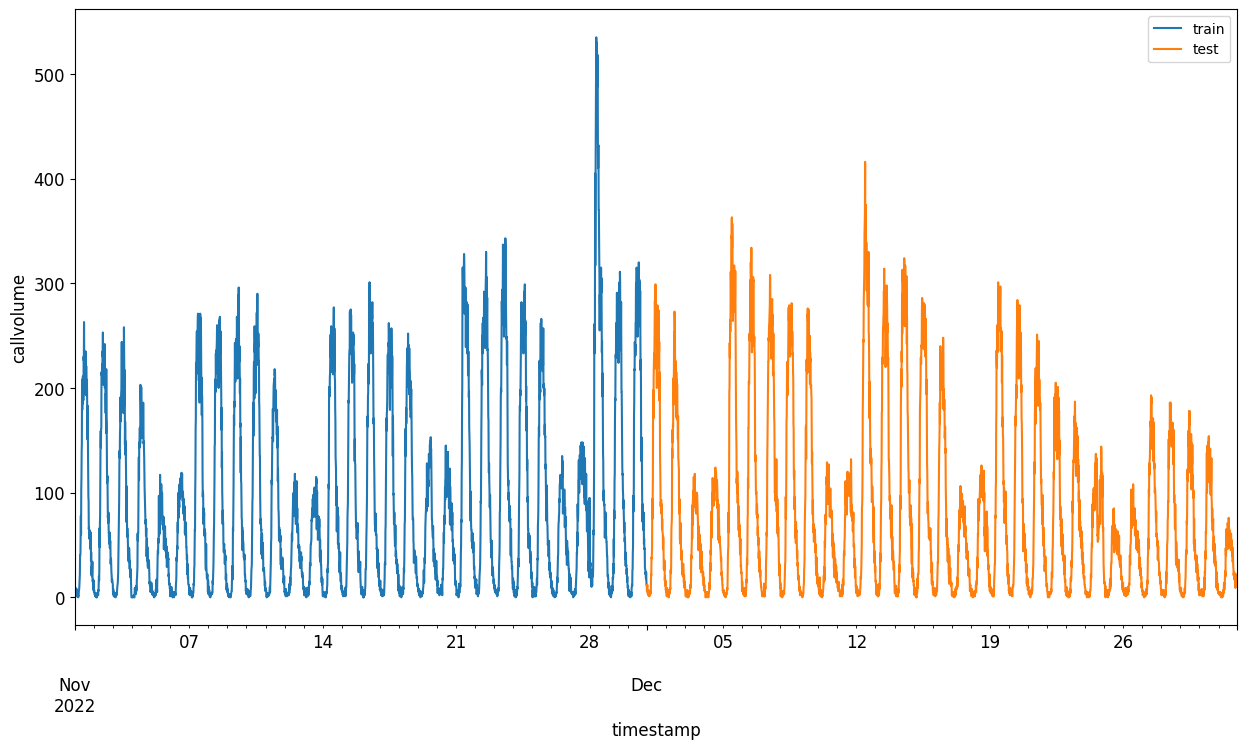

In [17]:
ts_df[(ts_df.index < test_start_dt) & (ts_df.index >= train_start_dt)][['callvolume']].rename(columns={'callvolume':'train'}) \
    .join(ts_df[test_start_dt:][['callvolume']].rename(columns={'callvolume':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('callvolume', fontsize=12)
plt.show()

In [18]:
train = ts_df.copy()[(ts_df.index >= train_start_dt) & (ts_df.index < test_start_dt)][['callvolume']]
test = ts_df.copy()[ts_df.index >= test_start_dt][['callvolume']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (2880, 1)
Test data shape:  (2976, 1)


In [19]:
# train_size = int(len(ts_df) * 0.8)
# train, test = ts_df.iloc[:train_size], ts_df.iloc[train_size:]
# print('Training data shape: ', train.shape)
# print('Test data shape: ', test.shape)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['callvolume'] = scaler.fit_transform(train)

In [21]:
test['callvolume'] = scaler.transform(test)

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

my_order = (2,1,2)
my_seasonal_order = (1, 1, 1, 96)
# define model
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [23]:
from time import time

#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94605D+00    |proj g|=  8.02339D+00


 This problem is unconstrained.



At iterate    5    f= -1.97632D+00    |proj g|=  8.82386D-01

At iterate   10    f= -1.98912D+00    |proj g|=  6.70296D-01

At iterate   15    f= -1.99368D+00    |proj g|=  1.29210D+00

At iterate   20    f= -2.04626D+00    |proj g|=  3.35893D+00

At iterate   25    f= -2.05155D+00    |proj g|=  2.35863D-01

At iterate   30    f= -2.05560D+00    |proj g|=  5.38697D-02

At iterate   35    f= -2.06037D+00    |proj g|=  1.85281D-01

At iterate   40    f= -2.06078D+00    |proj g|=  1.41250D-01

At iterate   45    f= -2.06284D+00    |proj g|=  1.05866D+00

At iterate   50    f= -2.06662D+00    |proj g|=  1.12607D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Fitting Time: 1185.0812847614288


In [24]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           callvolume   No. Observations:                 2880
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 96)   Log Likelihood                5951.867
Date:                              Fri, 14 Jul 2023   AIC                         -11889.734
Time:                                      09:47:39   BIC                         -11848.215
Sample:                                  11-01-2022   HQIC                        -11874.743
                                       - 11-30-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5379      0.056      9.609      0.000       0.428       0.648
ar.L2         -0.15

In [25]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.10124978221925449
